# Sentiment Analysis with an RNN

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

<img src="http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png">
<p style="font-size:10px;">http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png</p>

## What is Sentiment Analysis?

Sentiment Analysis also know as opinion mining refers to the identification, extraction and study of sentiment states by using natural language processing, text analysis, computational linguistics and biometrics.

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports

In [37]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout, CuDNNLSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.python.client import device_lib

In [38]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

In [40]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

***If TF can access GPU: ***

 True


In [41]:
value = tf.config.list_physical_devices('GPU')
print(value)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8822222846322210882
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7709554403894443961
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12549783839395500457
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5732226320994594458
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [43]:
tf.debugging.set_log_device_placement(True)

In [44]:
 tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


<module 'tensorflow' from '/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow/__init__.py'>

Num GPUs Available:  1


# Place tensors on the CPU
# with tf.device('/GPU:0'):
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)


### Loading in Dataset

In [45]:
data1 = pd.read_csv('Tweets.csv')
data2 = pd.read_csv('stanford-tweets.csv',sep=',')
# data1 = data1.sample(frac=1).reset_index(drop=True)
# data2 = data2.sample(frac=1).reset_index(drop=True)
print(data1.shape)
print(data2.shape)

data1.head()
data2.head()

(14640, 15)
(1600000, 2)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


Removing all columns except the airline_sentiment and text column.

In [46]:
data1 = data1[['airline_sentiment', 'text']]
new_columns = ['sentiment','text']
data1.columns = new_columns
data1.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [47]:
df = data1.append(data2, ignore_index = True) 
print(df.shape)
df

(1614640, 2)


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
1614635,positive,Just woke up. Having no school is the best fee...
1614636,positive,TheWDB.com - Very cool to hear old Walt interv...
1614637,positive,Are you ready for your MoJo Makeover? Ask me f...
1614638,positive,Happy 38th Birthday to my boo of alll time!!! ...


### Data exploration

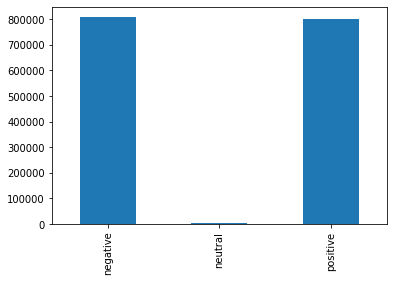

In [48]:
df['sentiment'].value_counts().sort_index().plot.bar()

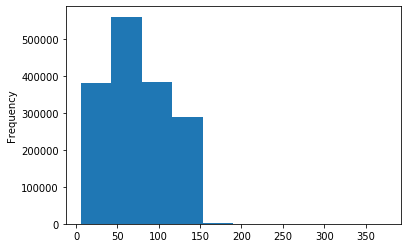

In [49]:
df['text'].str.len().plot.hist()

### Preprocessing

In [50]:
# data['text'] = data['text'].str.replace('@VirginAmerica', '')
# data.head()
df = df.sample(frac=1).reset_index(drop=True)
df

,sentiment,text
0,positive,@cmontoya it's different because i make being ...
1,positive,i'm following 69 people on twitter. heh.
2,positive,just woke up.feeling great..gonna eat breakfas...
3,negative,@FelipaFTWNoSyke http://twitpic.com/6ao2y - I ...
4,positive,I am making beef stew with Guinness. YEAH.
...,...,...
1614635,negative,Well this is just very upsetting. I'm going to...
1614636,positive,@Kameronkupkake kewlio i just made the weirde...
1614637,negative,blisss......macdonalds always does the trick ....
1614638,positive,Star Trek is gooooooooooooooood !


In [51]:
df['text'].apply(lambda x: x.lower()) #transform text to lowercase
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
df['text'].head()

0          @cmontoya it's different because i make being ...
1                  i'm following 69 people on twitter. heh. 
2          just woke up.feeling great..gonna eat breakfas...
3          @felipaftwnosyke http://twitpic.com/6ao2y - i ...
4                i am making beef stew with guinness. yeah. 
                                 ...                        
1614635    well this is just very upsetting. i'm going to...
1614636    @kameronkupkake kewlio  i just made the weirde...
1614637    blisss......macdonalds always does the trick ....
1614638                   star trek is gooooooooooooooood ! 
1614639                         @johncleese i'm not working 
Name: text, Length: 1614640, dtype: object

0    cmontoya its different because i make being ge...
1               im following 69 people on twitter heh 
2    just woke upfeeling greatgonna eat breakfast t...
3    FelipaFTWNoSyke httptwitpiccom6ao2y  I should ...
4            I am making beef stew with Guinness YEAH 
Name: text, dtype: object

In [53]:
df['sentiment']

0          positive
1          positive
2          positive
3          negative
4          positive
             ...   
1614635    negative
1614636    positive
1614637    negative
1614638    positive
1614639    negative
Name: sentiment, Length: 1614640, dtype: object

In [54]:
df = df[df['sentiment'] != 'neutral']

In [55]:
df

,sentiment,text
0,positive,cmontoya its different because i make being ge...
1,positive,im following 69 people on twitter heh
2,positive,just woke upfeeling greatgonna eat breakfast t...
3,negative,FelipaFTWNoSyke httptwitpiccom6ao2y I should ...
4,positive,I am making beef stew with Guinness YEAH
...,...,...
1614635,negative,Well this is just very upsetting Im going to b...
1614636,positive,Kameronkupkake kewlio i just made the weirdes...
1614637,negative,blisssmacdonalds always does the trick actuall...
1614638,positive,Star Trek is gooooooooooooooood


In [56]:
# from numba import jit, cuda 

In [67]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(df['text'].values)

X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          24,  847,  203,    1,  124,  171,  350],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   13,  418,  144,   14,  100, 1680],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   20,  340,
         362,  536,   92,  655,    1,  111,  145,   26,  131,  194, 2923,
           8,   78,  229,  936,    1,   46,  138],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           1,  136,  442,   79,  

### Creating model

In [68]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


In [69]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 256)           1280000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 40, 256)           525312    
_________________________________________________________________
lstm_19 (LSTM)               (None, 40, 256)           525312    
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 2,856,450
Trainable params: 2,856,450
Non-trainable params: 0
____________________________________________

In [70]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

positive [0 1]
positive [0 1]
positive [0 1]
negative [1 0]
positive [0 1]


[None, None, None, None, None]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [72]:
batch_size = 32
epochs = 7

import time

start = time.time()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")



/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
Executing op __inference_keras_scratch_graph_13511 in device /job:localhost/replica:0/task:0/device:GPU:0
 - 3473s - loss: 0.4298 - accuracy: 0.8009
Epoch 2/7
 - 3461s - loss: 0.4020 - accuracy: 0.8168
Epoch 3/7
 - 3462s - loss: 0.3956 - accuracy: 0.8203
Epoch 4/7
 - 3462s - loss: 0.3932 - accuracy: 0.8218
Epoch 5/7
 - 3461s - loss: 0.3925 - accuracy: 0.8221
Epoch 6/7
 - 3459s - loss: 0.3927 - accuracy: 0.8223
Epoch 7/7
 - 3459s - loss: 0.3930 - accuracy: 0.8222


403.9781750917435  minutes


In [73]:
model.save('sentiment_analysis-22012020.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


### Testing model

In [74]:
predictions = model.predict(X_test)

[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

Executing op __inference_keras_scratch_graph_1706144 in device /job:localhost/replica:0/task:0/device:GPU:0
cmontoya its different because i make being geeky cute  [0.92575616 0.07405306] [1 0]
im following 69 people on twitter heh  [0.29953572 0.70046616] [0 1]
just woke upfeeling greatgonna eat breakfast then church i wish school was over already thurs is when summer starts i cant wait  [0.97889256 0.02137248] [1 0]
FelipaFTWNoSyke httptwitpiccom6ao2y  I should b there hahaha lol  have fun girlies i knw yall arent cuz i am not there lmao [0.16216214 0.8377718 ] [0 1]
I am making beef stew with Guinness YEAH  [0.94135034 0.05848065] [1 0]


[None, None, None, None, None]

In [75]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  322309
Number of accurate predictions:  264891
Number of false predictions:  57418
Accuracy:  0.8218541834078478


In [ ]:
# pos_count, neu_count, neg_count = 0, 0, 0
# real_pos, real_neu, real_neg = 0, 0, 0
# for i, prediction in enumerate(predictions):
#     if np.argmax(prediction)==2:
#         pos_count += 1
#     elif np.argmax(prediction)==1:
#         neu_count += 1
#     else:
#         neg_count += 1
    
#     if np.argmax(y_test[i])==2:
#         real_pos += 1
#     elif np.argmax(y_test[i])==1:    
#         real_neu += 1
#     else:
#         real_neg +=1

# print('Positive predictions:', pos_count)
# print('Neutral predictions:', neu_count)
# print('Negative predictions:', neg_count)
# print('Real positive:', real_pos)
# print('Real neutral:', real_neu)
# print('Real negative:', real_neg)

## Improvements we could implement
<ul>
    <li>Weight classes (because data is skew)</li>
    <li>Train more epochs</li>
    <li>Use bigger network</li>
    <li>Try other word number</li>
</ul>

## Resources

<ul>
    <li><a href="https://programmingwithgilbert.firebaseapp.com/videos/machine-learning-explained/recurrent-neural-networks-lstm-explained">Recurrent Neural Networks Explained (my own post and video)</a></li>
    <li><a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment Analysis (Wikipedia)</a></li>
    <li><a href="https://www.quora.com/What-is-the-best-way-to-do-sentiment-analysis-with-Python-I%E2%80%99m-looking-for-a-sentiment-analysis-API-that-I-can-add-an-emoticon-dictionary-to-I-have-no-idea-how-to-use-NLTK-Can-anyone-help-me-with-that">What is the best way to do sentiment analysis with Python? (Quora)</a></li>
    <li><a href="https://www.youtube.com/watch?v=si8zZHkufRY">How to Do Sentiment Analysis (Siraj Raval)</a></li>
</ul>